In [1]:
from aesahaettr.aesahaettr import calamity
from aesahaettr.aesahaettr import covariances
from aesahaettr.aesahaettr import visibilities
import copy
import numpy as np
import tensorflow as tf

import matplotlib.pyplot as plt

/Users/aewallwi/miniconda3/envs/hera3/lib/python3.7/site-packages/hera_sim/visibilities/__init__.py:22: UserWarning: HealVis failed to import.
  warnings.warn("HealVis failed to import.")
/Users/aewallwi/miniconda3/envs/hera3/lib/python3.7/site-packages/hera_sim/visibilities/__init__.py:27: UserWarning: PRISim failed to import.
  warnings.warn("PRISim failed to import.")
/Users/aewallwi/miniconda3/envs/hera3/lib/python3.7/site-packages/hera_sim/visibilities/__init__.py:33: UserWarning: VisGPU failed to import.
  warnings.warn("VisGPU failed to import.")
/Users/aewallwi/miniconda3/envs/hera3/lib/python3.7/site-packages/hera_sim/__init__.py:37: FutureWarning: 
In the next major release, all HERA-specific variables will be removed from the codebase. The following variables will need to be accessed through new class-like structures to be introduced in the next major release: 

noise.HERA_Tsky_mdl
noise.HERA_BEAM_POLY
sigchain.HERA_NRAO_BANDPASS
rfi.HERA_RFI_STATIONS

Additionally, the next

In [52]:
# test fitting foregrounds
uvd_gsm, uvd_eor = visibilities.compute_visibilities(output_dir='./', nside_sky=128, antenna_count=10,
                                                       nf=100, df=400e3, f0=150e6, antenna_diameter=2.,
                                                       fractional_spacing=5)
uvd_total = copy.deepcopy(uvd_gsm)
uvd_total.data_array += uvd_eor.data_array

evals, evecs = covariances.cov_mat_simple_evecs(uvdata=uvd_total, antenna_diameter=2., eigenval_cutoff=1e-6, antenna_chromaticity=2. / 3e8)
# initialize with true foreground coefficients
# plus a perturbation.
data = copy.deepcopy(uvd_total.data_array.squeeze()).reshape(uvd_total.Nbls * uvd_total.Nfreqs) 
mdata = np.mean(data) * 0
data -= mdata
rmsdata = np.sqrt(np.mean(np.abs(data) ** 2.))
data /= rmsdata
fg_coeffs_true = evecs.T @ data
fg_coeffs = fg_coeffs_true + .1 * fg_coeffs_true * (np.random.randn(len(fg_coeffs_true)))

invalid value encountered in sqrt


KeyboardInterrupt: 

In [40]:
weights = tf.convert_to_tensor(np.ones(data.shape, dtype=np.float64))

foreground_coefficients_real = tf.Variable(tf.convert_to_tensor(fg_coeffs.real))
foreground_coefficients_imag = tf.Variable(tf.convert_to_tensor(fg_coeffs.imag))

foreground_basis_vectors = tf.convert_to_tensor(evecs)

data_real = tf.convert_to_tensor(data.real)
data_imag = tf.convert_to_tensor(data.imag)

loss = lambda: .5 * tf.reduce_sum(tf.math.square(data_real - tf.math.reduce_sum(foreground_basis_vectors * foreground_coefficients_real, axis=1) * weights)) \
               + .5 * tf.reduce_sum(tf.math.square(data_imag - tf.math.reduce_sum(foreground_basis_vectors * foreground_coefficients_imag, axis=1) * weights))

opt = tf.optimizers.Adamax()

foreground_coefficients_real_last = foreground_coefficients_real.numpy()
foreground_coefficients_imag_last = foreground_coefficients_imag.numpy()
opt.minimize(loss, [foreground_coefficients_real, foreground_coefficients_imag])

delta_real = np.abs(foreground_coefficients_real.numpy() - foreground_coefficients_real_last).max()
delta_imag = np.abs(foreground_coefficients_imag.numpy() - foreground_coefficients_imag_last).max()




In [41]:
var_history_real = []
var_history_imag = []
tol = 1e-5
step = 0
maxsteps = 2500
while (delta_real >= tol and delta_imag >= tol) or step < maxsteps:
    opt.minimize(loss, [foreground_coefficients_real, foreground_coefficients_imag])
    delta_real = np.abs(foreground_coefficients_real.numpy() - foreground_coefficients_real_last).max()
    delta_imag = np.abs(foreground_coefficients_imag.numpy() - foreground_coefficients_imag_last).max()
    foreground_coefficients_real_last = foreground_coefficients_real.numpy()
    var_history_real.append(foreground_coefficients_real_last)
    foreground_coefficients_imag_last = foreground_coefficients_imag.numpy()
    var_history_imag.append(foreground_coefficients_imag_last)
    step += 1

In [42]:
foreground_coefficients = foreground_coefficients_real.numpy() + 1j * foreground_coefficients_imag.numpy()
foreground_model = (foreground_basis_vectors.numpy() @ foreground_coefficients).reshape(uvd_eor.Nbls, uvd_eor.Nfreqs)
foreground_model = foreground_model * rmsdata + mdata

In [43]:
len(fg_coeffs_true)

780

In [44]:
foreground_model_true = (foreground_basis_vectors.numpy() @ fg_coeffs_true).reshape(uvd_eor.Nbls, uvd_eor.Nfreqs)
foreground_model_true = foreground_model_true * rmsdata + mdata

In [50]:
len(fg_coeffs_true) + uvd_eor.Nants_data * uvd_eor.Nfreqs

980

In [51]:
len(data)

920

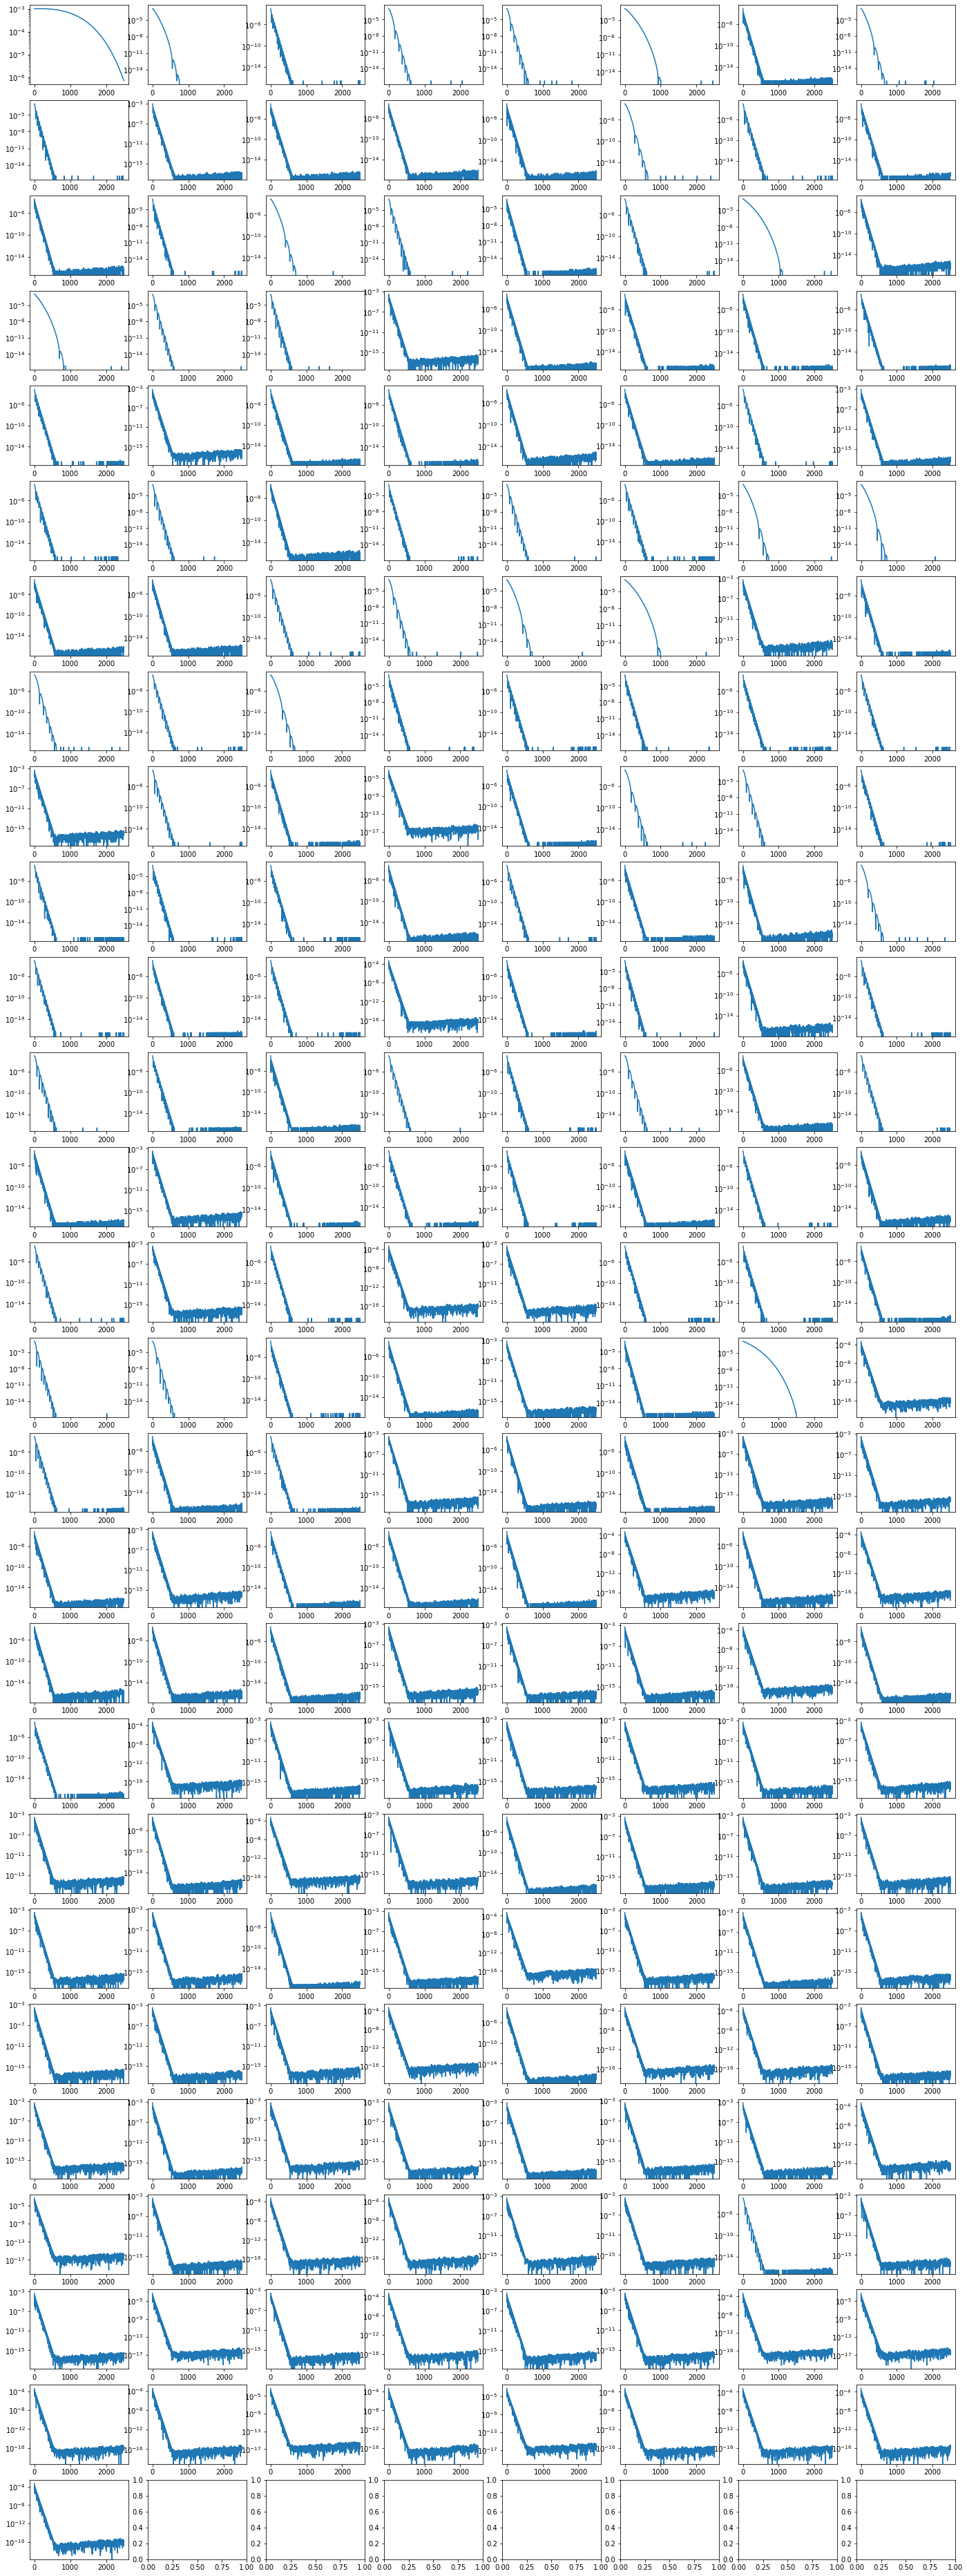

In [27]:
fig, axarr = plt.subplots(len(fg_coeffs)//8 + 1, 8)
fig.set_size_inches(24, 68)
for i in range(len(var_history_real[0])):
    l = i % 8
    m = i // 8
    plt.sca(axarr[m][l])
    plt.plot(np.abs(np.diff(np.asarray(var_history_real).T[i])))
    plt.yscale('log')
plt.show()


In [11]:
delta_imag

5.483894588431681e-16

Casting complex values to real discards the imaginary part


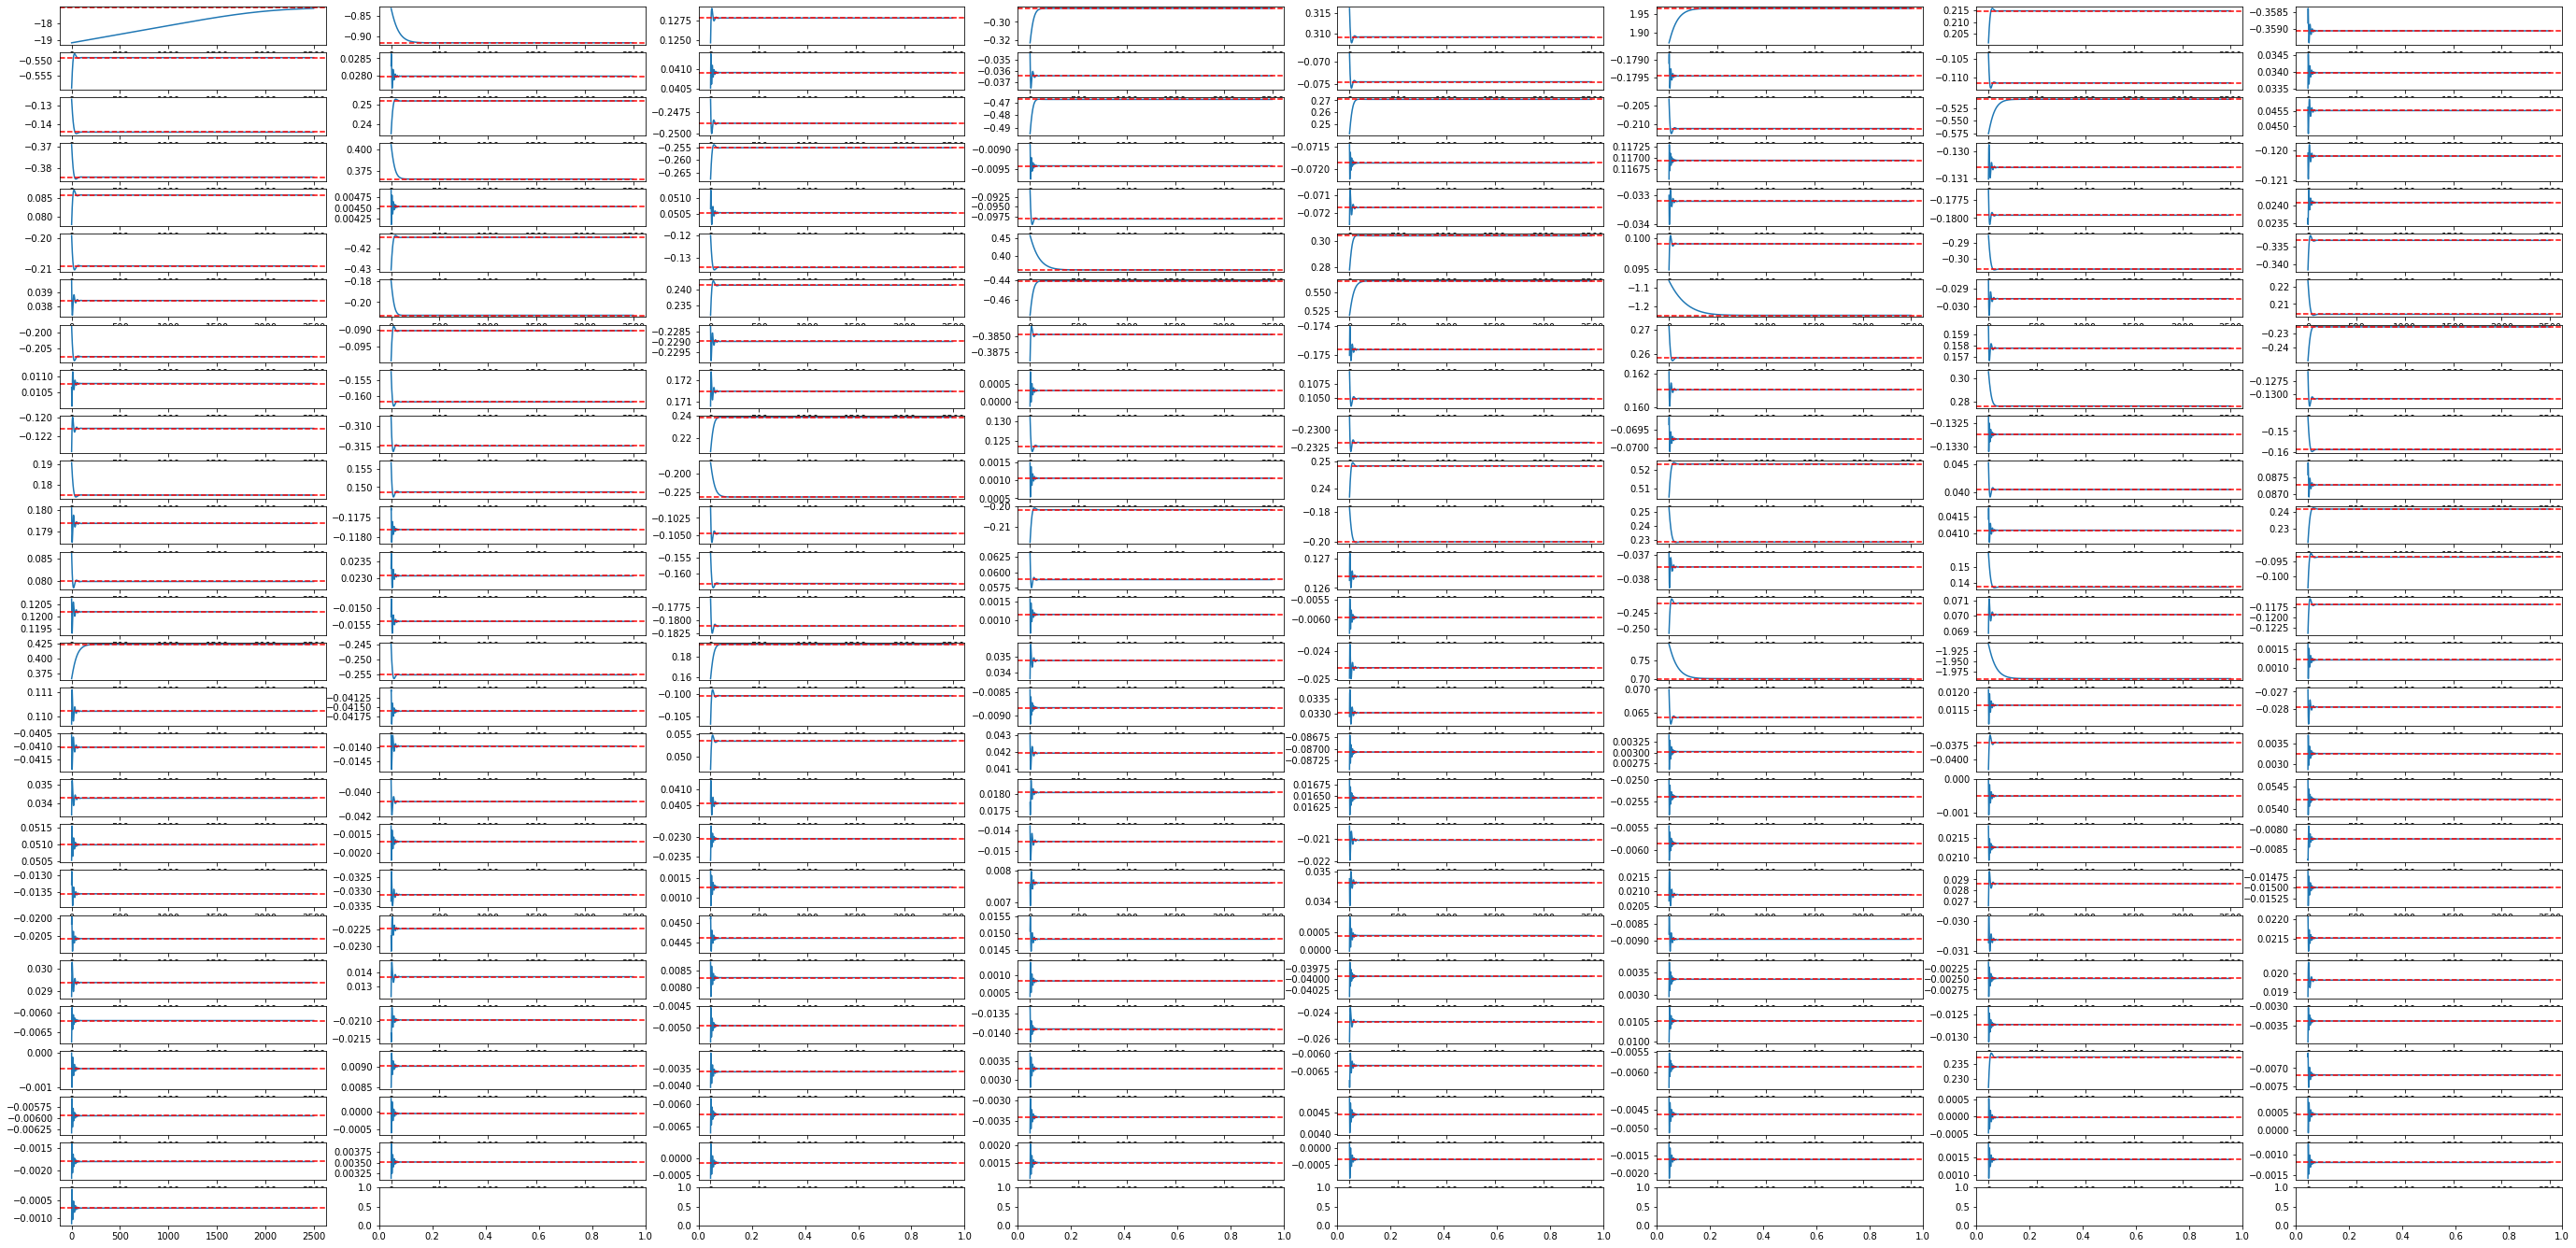

In [133]:
fig, axarr = plt.subplots(len(fg_coeffs)//8 + 1, 8)
fig.set_size_inches(48, 24)
for i in range(len(var_history_real[0])):
    l = i % 8
    m = i // 8
    plt.sca(axarr[m][l])
    plt.plot(np.asarray(var_history_real).T[i])
    plt.axhline(fg_coeffs_true[i], ls='--', color='r')
plt.show()


In [15]:
foreground_model.shape

(16, 20)

In [16]:
uvd_total.data_array.shape

(16, 1, 20, 1)

In [34]:
uvd_gsm.Nbls * uvd_gsm.Nfreqs

320

In [37]:
uvd_gsm.Nants_data * uvd_gsm.Nfreqs

120

In [38]:
len(fg_coeffs_true)

209

Casting complex values to real discards the imaginary part


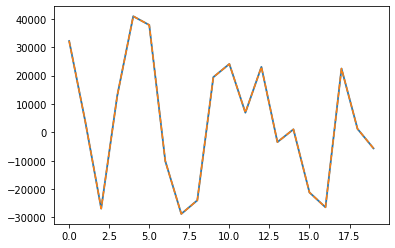

In [31]:
vindex = 12
plt.plot(uvd_total.data_array[vindex].squeeze(), label='true data', color='grey', alpha=.5, lw=2)
plt.plot(foreground_model_true[vindex].squeeze(), label='true model')
plt.plot(foreground_model[vindex].squeeze(), ls='--', label='fitted model')

In [18]:
delta_imag

5.483894588431681e-16

In [68]:
delta_real

6.179157452379513e-08

In [85]:
opt = tf.optimizers.RMSprop(learning_rate=1e-3)
x = tf.Variable(2.34)
loss = lambda: (x - 1.2163125124613465) ** 2.
xlast = x.numpy()
opt.minimize(loss, var_list=[x])
deltax = np.abs(x.numpy() / xlast - 1.)
tol=1e-5
while deltax > tol:
    opt.minimize(loss, var_list=[x])
    deltax = np.abs(x.numpy() / xlast - 1.)
    xlast = x.numpy()

In [6]:
opt = tf.optimizers.RMSprop(learning_rate=1e-3)
x = tf.Variable([2.34, 1.234])
loss = lambda: (x[0] - 1.2163125124613465) ** 2. + (x[1] - 2.245236) ** 2.
xlast = x.numpy()
opt.minimize(loss, var_list=[x])
deltax = np.abs(x.numpy() / xlast - 1.)
tol=1e-5
while np.all(deltax > tol):
    opt.minimize(loss, var_list=[x])
    deltax = np.abs(x.numpy() / xlast - 1.)
    xlast = x.numpy()

In [7]:
x

<tf.Variable 'Variable:0' shape=(2,) dtype=float32, numpy=array([1.2889105, 2.2451856], dtype=float32)>

In [8]:
opt.iterations

<tf.Variable 'RMSprop/iter:0' shape=() dtype=int64, numpy=1066>